In [1]:
import featuretools as ft
import pandas as pd
import numpy as np
import seaborn as sns
import simfin as sf
import math
import datetime as date
from datetime import timedelta  
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")

## Inverse Mean Reversion Algorithm on Equities: mplementation of Statistical Arbitrage Fundamental and anomaly estimation using the Ornstein-Ulhenbeck Process

In [2]:
#collect data from api
sf.set_api_key('PLEbHyzQgm98TrvHFejzBwikq1mKiJob ')
sf.set_data_dir('~/simfin_data/')
sf.set_data_dir('C:/Users/suher/Python/Springboard/Capstone 2')
figures_and_ratios = sf.load_derived(variant = 'quarterly',market = 'us')
sector_industry = sf.load_industries()
balance_sheet = sf.load_balance(variant='quarterly-full', market='us')
companies = sf.load_companies(market='us')
cash_flow = sf.load_cashflow(variant='quarterly-full', market='us')
income_statement = sf.load_income(variant='quarterly-full', market='us')
historical_prices = sf.load_shareprices(variant = 'daily', market = 'us',refresh_days = 1)
price_ratios = sf.load_derived_shareprices(variant='daily', market='us',refresh_days = 1)


sp500_daily = pd.read_csv('sp500daily.csv')
sp500_list = list(pd.read_csv('constituents_csv.csv')['Symbol'])
sp500_daily.Date =  pd.to_datetime(sp500_daily.Date)

hp = historical_prices.reset_index()
hp = hp[hp['Ticker'].isin(sp500_list)]
companies = companies.reset_index()
companies = companies[companies['Ticker'].isin(sp500_list)]

sector_industry.Sector.unique()

sp500_daily.set_index('Date',inplace=True)

sector_industry.reset_index(inplace=True)
comp_sector = pd.merge(companies,sector_industry,how='left',left_on='IndustryId',right_on='IndustryId')

hp_ = pd.merge(hp,comp_sector[['SimFinId','Sector']],how='left',left_on='SimFinId',right_on='SimFinId')

t_hp = hp_[hp_['Sector'] == 'Technology']
f_hp = hp_[hp_['Sector'] == 'Financial Services']
s_hp = sp500_daily[['Open','Close']]

#s = SPX, t = TECH STOCKS, f = FINANCIAL STOCKS
s_open = s_hp.Open
s_close = s_hp.Close
t_open = t_hp.set_index('Date').pivot(columns='Ticker',values='Open')
t_close = t_hp.set_index('Date').pivot(columns='Ticker',values='Close')
f_open = f_hp.set_index('Date').pivot(columns='Ticker',values='Open')
f_close = f_hp.set_index('Date').pivot(columns='Ticker',values='Close')

st_close = pd.DataFrame(s_close).join(t_close)
st_close.rename(columns={'Close':'SPX'},inplace=True)
st_close_ret = st_close.pct_change().iloc[1:,:]

Dataset "us-derived-quarterly" on disk (15 days old).
- Loading from disk ... Done!
Dataset "industries" on disk (15 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly-full" on disk (13 days old).
- Loading from disk ... Done!
Dataset "us-companies" on disk (15 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly-full" on disk (13 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly-full" on disk (13 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-derived-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!


In [3]:
st_close

,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,SWKS,TEL,TTWO,TWTR,TXN,TYL,VRSN,WDC,XLNX,XRX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1132.989990,7.64,37.09,31.67,25.67,25.92,14.30,9.70,NaN,44.64,...,14.82,25.03,10.40,NaN,26.01,20.30,24.74,45.26,25.38,34.52
2010-01-05,1136.520020,7.66,37.70,31.62,25.28,26.69,14.19,9.71,NaN,43.64,...,15.05,24.66,10.47,NaN,25.86,20.78,25.00,46.46,25.06,34.56
2010-01-06,1137.140015,7.53,37.62,31.56,25.34,26.47,14.16,9.57,NaN,43.35,...,14.91,25.16,10.44,NaN,25.67,20.77,24.73,46.50,24.89,34.24
2010-01-07,1141.689941,7.52,36.89,31.31,25.48,26.48,14.01,9.47,NaN,43.46,...,14.74,24.69,10.39,NaN,25.75,20.50,24.39,45.59,24.64,34.40
2010-01-08,1144.979980,7.57,36.69,31.49,26.26,26.48,14.55,9.43,NaN,43.76,...,15.00,25.00,10.42,NaN,26.34,20.74,24.58,45.82,25.00,34.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,3223.379883,71.07,329.64,119.72,183.91,85.73,61.50,46.54,204.64,256.49,...,122.16,95.20,123.93,32.50,128.53,298.39,192.75,62.23,98.49,37.37
2019-12-26,3239.909912,72.48,331.20,119.73,184.24,86.34,61.31,46.63,205.61,258.33,...,122.28,95.31,123.99,32.63,128.48,300.44,193.71,62.80,98.68,37.48
2019-12-27,3240.020020,72.45,330.79,119.45,185.38,86.50,61.17,46.18,204.43,258.68,...,122.29,95.51,124.47,32.55,128.57,300.57,194.05,62.13,98.42,37.31



Check daily returns data integrity by testing stationarity (anderson-fuller test).

In [4]:
st_close_ret

,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,SWKS,TEL,TTWO,TWTR,TXN,TYL,VRSN,WDC,XLNX,XRX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.003116,0.002618,0.016446,-0.001579,-0.015193,0.029707,-0.007692,0.001031,NaN,-0.022401,...,0.015520,-0.014782,0.006731,NaN,-0.005767,0.023645,0.010509,0.026513,-0.012608,0.001159
2010-01-06,0.000546,-0.016971,-0.002122,-0.001898,0.002373,-0.008243,-0.002114,-0.014418,NaN,-0.006645,...,-0.009302,0.020276,-0.002865,NaN,-0.007347,-0.000481,-0.010800,0.000861,-0.006784,-0.009259
2010-01-07,0.004001,-0.001328,-0.019405,-0.007921,0.005525,0.000378,-0.010593,-0.010449,NaN,0.002537,...,-0.011402,-0.018680,-0.004789,NaN,0.003116,-0.013000,-0.013748,-0.019570,-0.010044,0.004673
2010-01-08,0.002882,0.006649,-0.005422,0.005749,0.030612,0.000000,0.038544,-0.004224,NaN,0.006903,...,0.017639,0.012556,0.002887,NaN,0.022913,0.011707,0.007790,0.005045,0.014610,-0.003488
2010-01-11,0.001747,-0.009247,-0.013083,-0.005716,-0.000381,-0.003399,0.021993,-0.030753,NaN,0.003885,...,0.000667,-0.008800,0.024952,NaN,-0.012908,-0.011090,-0.002848,0.001091,-0.010400,0.024504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.000195,0.000986,0.002098,0.004615,0.005412,-0.002095,0.006876,0.023757,-0.001123,0.002972,...,0.017746,0.001262,0.014821,0.002158,-0.000156,0.003295,0.001663,-0.007496,-0.004146,0.000535
2019-12-26,0.005128,0.019840,0.004732,0.000084,0.001794,0.007115,-0.003089,0.001934,0.004740,0.007174,...,0.000982,0.001155,0.000484,0.004000,-0.000389,0.006870,0.004981,0.009160,0.001929,0.002944
2019-12-27,0.000034,-0.000414,-0.001238,-0.002339,0.006188,0.001853,-0.002283,-0.009650,-0.005739,0.001355,...,0.000082,0.002098,0.003871,-0.002452,0.000700,0.000433,0.001755,-0.010669,-0.002635,-0.004536


In [5]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df): 
    adf_scores = []
    for i in list(df.columns): 
        curr_adf = adfuller(df[i].dropna())
        if curr_adf[1] > .05: 
            print('return of '+ i +'is not stationary')
        adf_scores.append(curr_adf[1])
    print(adf_scores)   
    
check_stationarity(st_close_ret)

[5.553316228250892e-21, 0.0, 0.0, 0.0, 4.9922408583287756e-27, 0.0, 2.038736506225406e-30, 0.0, 0.0, 0.0, 0.0, 4.381051964154431e-29, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.493561648922373e-26, 0.0, 0.0, 0.0, 0.0, 4.38949639290485e-26, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.360825648999867e-30, 0.0, 0.0, 0.0, 8.111678817735038e-28, 1.6110881279268902e-27, 7.96407307737618e-18, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.904098580702446e-19, 0.0, 0.0, 0.0, 0.0, 0.0]


Checking integrity of data returns are stationary, proceeding to EDA on tech daily returns.

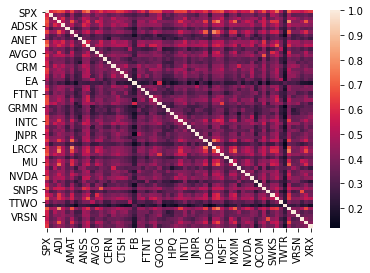

In [6]:
st_cormat = st_close_ret.corr()

sns.heatmap(st_cormat)

In [7]:
st_cormat.head()

,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,SWKS,TEL,TTWO,TWTR,TXN,TYL,VRSN,WDC,XLNX,XRX
SPX,1.000000,0.594454,0.640472,0.683298,0.653121,0.508136,0.647975,0.447742,0.405457,0.676361,...,0.583891,0.735098,0.498561,0.299533,0.702269,0.572662,0.565424,0.535550,0.589004,0.622795
AAPL,0.594454,1.000000,0.391650,0.451282,0.404948,0.288814,0.449266,0.301571,0.290395,0.420987,...,0.495559,0.443582,0.337278,0.246508,0.466154,0.336545,0.344159,0.342228,0.368228,0.328292
ADBE,0.640472,0.391650,1.000000,0.489951,0.597206,0.377447,0.474976,0.327088,0.381254,0.544977,...,0.385006,0.473604,0.417703,0.286828,0.488523,0.501832,0.426522,0.371542,0.436130,0.388711
ADI,0.683298,0.451282,0.489951,1.000000,0.518988,0.392218,0.668798,0.436903,0.336469,0.510570,...,0.623242,0.619291,0.385259,0.253183,0.790528,0.417567,0.409653,0.487627,0.687649,0.454002
ADSK,0.653121,0.404948,0.597206,0.518988,1.000000,0.403540,0.517180,0.360747,0.386889,0.593243,...,0.467301,0.539521,0.382253,0.293418,0.527280,0.456132,0.451628,0.433908,0.460370,0.418679


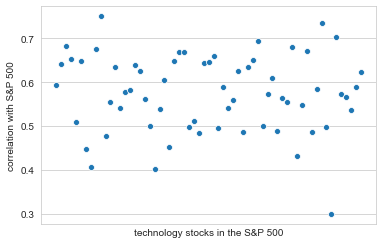

In [8]:
sns.set_style('whitegrid')
spcor = sns.scatterplot(x=st_cormat.columns[1:],y=st_cormat.SPX[1:]);
plt.ylabel('correlation with S&P 500');
plt.xlabel('technology stocks in the S&P 500');
spcor.axes.get_xaxis().set_ticks([]);

Test creating a base capm model.

In [9]:
tech_etf = ['IXN','IGM','IGV','XNTK','XLK','XSD','VGT','RYT','XSW']

etf_daily_close = pd.read_csv('IXN.csv')
etf_daily_close = etf_daily_close[['Date','Close']]
for i in tech_etf[1:]: 
    etf_csv = i +'.csv'
    etf_df = pd.read_csv(etf_csv)[['Date','Close']]
    etf_daily_close = pd.merge(etf_daily_close,etf_df,how='left',left_on='Date',right_on='Date')

pd.read_csv('IXN.csv').head()
etf_daily_close['Date'] = pd.to_datetime(etf_daily_close['Date'])
etf_daily_close.set_index('Date',inplace=True)
etf_daily_close.columns = tech_etf
etf_daily_ret = etf_daily_close.pct_change()[1:]
stETF = st_close_ret.join(etf_daily_ret)
stETF.head()


,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,XRX,IXN,IGM,IGV,XNTK,XLK,XSD,VGT,RYT,XSW
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.003116,0.002618,0.016446,-0.001579,-0.015193,0.029707,-0.007692,0.001031,NaN,-0.022401,...,0.001159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,0.000546,-0.016971,-0.002122,-0.001898,0.002373,-0.008243,-0.002114,-0.014418,NaN,-0.006645,...,-0.009259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,0.004001,-0.001328,-0.019405,-0.007921,0.005525,0.000378,-0.010593,-0.010449,NaN,0.002537,...,0.004673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,0.002882,0.006649,-0.005422,0.005749,0.030612,0.000000,0.038544,-0.004224,NaN,0.006903,...,-0.003488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,0.001747,-0.009247,-0.013083,-0.005716,-0.000381,-0.003399,0.021993,-0.030753,NaN,0.003885,...,0.024504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


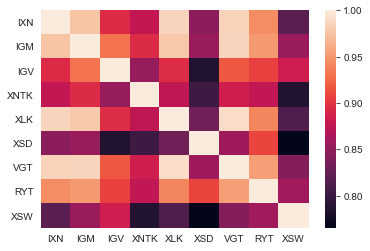

In [10]:
sns.heatmap(etf_daily_ret.corr())

trying in normal CAPM model on MSFT

In [11]:

import statsmodels.api as sm

stETF = st_close_ret.join(etf_daily_ret)

spx = stETF['SPX']
msft = stETF['MSFT']
x = sm.add_constant(spx)
lr = sm.OLS(msft,x)
results = lr.fit()
msft_spx = results.predict(x)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     2328.
Date:                Mon, 09 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:52:23   Log-Likelihood:                 7932.8
No. Observations:                2515   AIC:                        -1.586e+04
Df Residuals:                    2513   BIC:                        -1.585e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.254      0.210      -0.000       0.001
SPX            1.0688      0.022     48.253      0.000       1.025       1.112
==============================================================================
Omnibus:                      598.950   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29908.667
Skew:                           0.187   Prob(JB):                         0.00
Kurtosis:                      19.890   Cond. No.                         108.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
np.cumprod(stETF['SPX']+1)

Date
2010-01-05    1.003116
2010-01-06    1.003663
2010-01-07    1.007679
2010-01-08    1.010583
2010-01-11    1.012348
                ...   
2019-12-24    2.845021
2019-12-26    2.859610
2019-12-27    2.859708
2019-12-30    2.843176
2019-12-31    2.851552
Name: SPX, Length: 2515, dtype: float64

In [32]:
msft_spx

Date
2010-01-05    0.003589
2010-01-06    0.000842
2010-01-07    0.004535
2010-01-08    0.003339
2010-01-11    0.002125
                ...   
2019-12-24    0.000050
2019-12-26    0.005739
2019-12-27    0.000295
2019-12-30   -0.005920
2019-12-31    0.003407
Length: 2515, dtype: float64

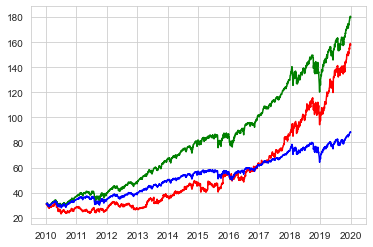

In [13]:
pred_msft = st_close.iloc[0]['MSFT'] * np.cumprod(msft_spx+1)
spx_ret = st_close.iloc[0]['MSFT'] * np.cumprod(stETF['SPX']+1)
plt.plot(st_close['MSFT'],'r')
plt.plot(pred_msft,'g')
plt.plot(spx_ret,'b')

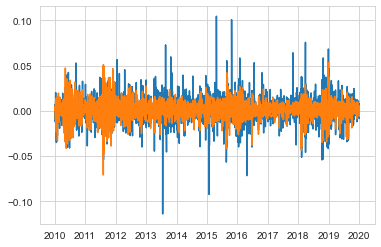

In [14]:
plt.plot(msft)
plt.plot(msft_spx)

In [15]:
x = stETF.loc[:,tech_etf].dropna()
y = stETF.loc[x.index[0]:x.index[-1],:]['MSFT']
#y = st_close_ret.loc[x.index[0],:]['GOOG'].dropna()
#x = st_close_ret.loc[y.index[0],:]['SPX']
x = sm.add_constant(x)
lr = sm.OLS(y,x)
results = lr.fit()
msft_etf = results.predict(x)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     381.6
Date:                Mon, 09 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:52:23   Log-Likelihood:                 6689.9
No. Observations:                2011   AIC:                        -1.336e+04
Df Residuals:                    2001   BIC:                        -1.330e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.217      0.224      -0.000       0.001
IXN           -0.0102      0.102     -0.100      0.921      -0.211       0.191
IGM            0.7274      0.120      6.074      0.000       0.493       0.962
IGV            0.4399      0.050      8.743      0.000       0.341       0.539
XNTK          -0.0087      0.031     -0.279      0.780      -0.070       0.052
XLK            0.9794      0.142      6.900      0.000       0.701       1.258
XSD           -0.1279      0.031     -4.117      0.000      -0.189      -0.067
VGT           -0.3365      0.169     -1.989      0.047      -0.668      -0.005
RYT           -0.3925      0.080     -4.916      0.000      -0.549      -0.236
XSW           -0.2158      0.036     -6.025      0.000      -0.286      -0.146
==============================================================================
Omnibus:                      516.236   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22003.487
Skew:                           0.418   Prob(JB):                         0.00
Kurtosis:                      19.183   Cond. No.                     1.04e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

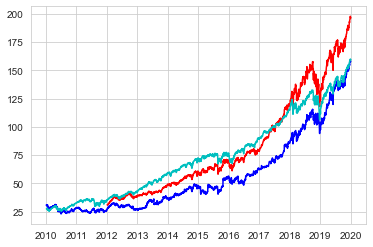

In [16]:
pred_msft_etf = st_close.iloc[0]['MSFT'] * np.cumprod(msft_etf+1)
pred_msft_ind = st_close.loc[pred_msft_etf.index[0]:]['MSFT'].iloc[0] * np.cumprod(msft_spx+1)
plt.plot(pred_msft_etf, 'r')
plt.plot(st_close['MSFT'], 'b')
plt.plot(pred_msft_ind, 'c')

In [17]:
def regress_pca(stock,pca_factors): 
    pca_f = PCA(n_components = 1)
    pca_f.fit(pca_factors)
    features = pca_f.transform(pca_factors)
    features = pd.DataFrame(features,index=pca_factors.index,columns=['etf_pca1'])
    x_pca = sm.add_constant(features)
    y = stock
    lr = sm.OLS(y,x_pca)
    results = lr.fit()
    alpha = results.params[0]
    beta1 = results.params[1]
    res = y - beta1 * x_pca.iloc[:,1] -alpha
    #beta2 = results.params[2]
    return alpha,beta1,res

def calc_ar1(residual): 
    ar1 = ARIMA(residual,order=(1,0,0)).fit()
    ar1_a = ar1.params[0]
    ar1_b = ar1.params[1]
    ar1_res  = ar1.resid
    return ar1_a,ar1_b,ar1_res

def compute_s_score(a,b,r):
    m = r.mean()
    if b > 0: 
        std_r_eq = r.std()/np.sqrt(2 * b)
    else: 
        std_r_eq =  r.std()/-np.sqrt(2 * abs(b))
    s = (r[-1]- m)/std_r_eq
    return s,std_r_eq,m

def calculate_signals(s,b,window): 
    signal = pd.DataFrame(columns = s.columns, index = s.index[window:])
    print(signal.index[-1])
    for i in range(0,s.shape[1]): 
        print('running for'+ " " + s.columns[i])
        try:
            for j in range(0,s.shape[0]-window+1):
                date = s.index[j + window -1]
                if(j%60 == 0): 
                    print("currently at iteration: "+ str(j))

                stock = s.iloc[j:j+window,i]
                pca_f = b.iloc[j:j+window,:]
                alpha,beta,res = regress_pca(stock,pca_f)
                #beta2 = results.params[2]           
                ar1_a,ar1_b,ar1_res = calc_ar1(res.mean() - res)
                day_s = compute_s_score(ar1_a,ar1_b,res)[0]
                signal.loc[date,s.columns[i]]=day_s

        except: 
            print('error calculating for: ' + s.columns[i])
    return signal
        
        
    

In [18]:
#test_run
stetf = stETF[stETF['IXN'].notna()]
s = stetf['AAPL']
b = stetf.loc[:,tech_etf]
alpha,beta,residual  = regress_pca(s,b)
a,b,r = calc_ar1(residual)
compute_s_score(a,b,r)

(0.10045325119534235, 0.03896492760063791, -1.9707451437280328e-07)

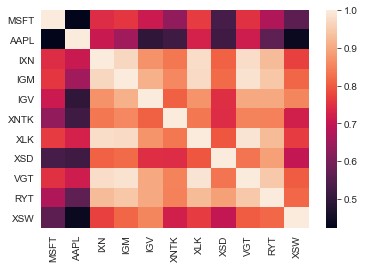

In [19]:
check_cor = stetf[['MSFT','AAPL']]
check_cor = check_cor.join(stetf.loc[:,tech_etf])
corr = check_cor.corr()[['MSFT','AAPL']]
sns.heatmap(check_cor.corr())

In [20]:
#s = stetf[['AAPL']]
#b = stetf.loc[:,tech_etf]
#windows = 60
#s_score = calculate_signals(s,b,windows)
#s_score = s_score.dropna()
#s_score.rename({'AAPL':'s_score'},axis=1,inplace=True)
#s_score = s_score.join(stetf['AAPL']+1)

In [21]:
#s = s_train.dropna(axis=1)
#b = s_train.loc[:,tech_etf]
#windows = 60

#s_score_all = calculate_signals(s,b,windows)
#s_score_all.to_csv('s_score_all_tech_train_115.csv')
#s_score_all = s_score_all[60:]
#s_score_all

In [22]:
s_tech =pd.read_csv('s_score_all_tech_train_115.csv').dropna(axis=1).dropna(axis=0).set_index('Date')
s_tech.index = pd.to_datetime(s_tech.index)
s_tech=s_tech[:-1]

In [54]:
s_aapl = pd.DataFrame(s_tech.AAPL)
s_aapl = s_aapl.join((stetf.AAPL+1),rsuffix='_ret')

In [55]:
s_score_train = pd.DataFrame(s_aapl).rename({'AAPL':'AAPL_s'},axis=1)

In [56]:
s_score_train.sort_values(by='AAPL_ret')

,AAPL_s,AAPL_ret
Date,,
2013-01-24,1.982536,0.876362
2014-01-28,3.529698,0.920142
2016-01-27,0.761299,0.934400
2012-12-05,0.569478,0.935343
2016-04-27,-3.233104,0.937141
...,...,...
2015-08-26,-0.220028,1.057462
2017-02-01,-2.442623,1.060976
2016-07-27,1.506201,1.064957


In [105]:
testret = pd.DataFrame([1,-2,1,-3])

In [104]:
testret = pd.DataFrame(b).pct_change()[1:]

In [116]:
def sim_long_arb(d_cut = -1,u_cut = 1,ret=False): 
    hold = False;
    day = 0
    cap=1
    daily_cap = [];
    returns = [];
    transaction_date = []
    for i in s_score_train.iterrows():
        daily_cap.append(cap)
        date = i[0]
        current_s = i[1][0]
        current_r = i[1][1]
        if hold == True: 
            cap = cap * current_r
            if current_s < d_cut: 
                hold = False
        if current_s > u_cut:
            transaction_date.append(i.index)
            hold = True
            
    cap_ret = pd.DataFrame(daily_cap).pct_change()[1:]
    ret_mean = float(cap_ret.mean())
    ret_std = float(cap_ret[cap_ret<0].std())
    if ret_std == 0: 
        ret_std=1
    sharpe = ret_mean/ret_std
    if ret == True: 
        return sharpe,returns
    else: 
        return sharpe

def sim_long_arb_cap(d_cut = -1,u_cut = 1,ret=False): 
    hold = False;
    cap=1
    daily_cap = []
    returns = [];
    transaction_date = []
    for i in s_score_train.iterrows():
        daily_cap.append(cap)
        date = i[0]
        current_s = i[1][0]
        current_r = i[1][1]
        if hold == True: 
            cap = cap * current_r
            if current_s < d_cut: 
                hold = False
        if current_s > u_cut:
            hold = True
            transaction_date.append(str(date))
    cap_ret = pd.DataFrame(daily_cap).pct_change()[1:]
    ret_mean = float(cap_ret.mean())
    ret_std = float(cap_ret.std())
    print(ret_mean)
    print(ret_std)
    if ret_std == 0: 
        ret_std=1
    sharpe = ret_mean/ret_std
    if ret == True: 
        return sharpe,returns
    else: 
        return sharpe, daily_cap,transaction_date

In [ ]:
opt_long = BayesianOptimization(sim_long_arb,{'d_cut':(-2,-1),'u_cut':(1,2)})
#opt_short = BayesianOptimization(sim_short_arb,{'d_cut':(-3,-1),'u_cut':(1,3)})
opt_long.maximize(n_iter = 100)
#opt_short.maximize(n_iter=10)

In [121]:
print(opt_long.max['params'],opt_long.max['target'])
#print(opt_short.max['params'],opt_short.max['target'])

{'d_cut': -1.4139317580122643, 'u_cut': 1.2893133840264919} 0.09491031965483433


0.0007907541645504562
0.010267407768789037


Text(0.5, 1.0, 'AAPL vs AAPL-w/algo')

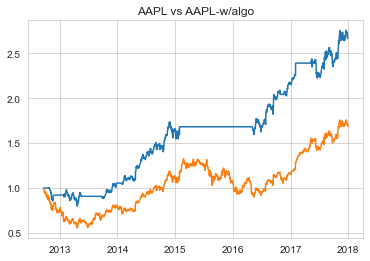

In [122]:
a,b,c = sim_long_arb_cap(opt_long.max['params']['d_cut'],1.3,ret=False)
aapl_ret_prod = s_score_train.AAPL_ret.cumprod()
buy_point = pd.to_datetime(c)
aapl_vs_algo = pd.DataFrame(b).join(aapl_ret_prod.reset_index()).set_index('Date')
plt.plot(aapl_vs_algo)
plt.title('AAPL vs AAPL-w/algo')


#### parameters are received after optimization for maximum sharpe/sortino ratio over entire dataset, this is to visualize what the "best-case scenario for this algo looks like or in other words, what the method is trying to achieve


In [123]:
s_tech

,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANSS,APH,...,XRX,IXN,IGM,IGV,XNTK,XLK,XSD,VGT,RYT,XSW
Date,,,,,,,,,,,,,,,,,,,,,
2012-09-19,0.002182,-0.115491,-0.927702,-0.161650,-0.074701,-0.084858,-0.720631,-0.225012,-0.018911,0.151089,...,-0.745755,0.175938,0.197009,-0.003281,-0.745626,0.058301,0.489492,-0.294453,-0.420030,-0.559318
2012-09-20,-0.431388,-0.157417,-0.742199,0.216406,-0.303148,-0.038930,0.109556,-0.009724,0.209156,0.004445,...,-0.231688,-0.054019,-0.883623,0.504389,-0.132158,-0.323444,1.122531,0.253131,0.042198,0.009563
2012-09-21,-0.035800,0.003126,0.691413,0.168824,-0.135759,-0.069252,0.111156,-0.173117,-0.132445,-0.036238,...,-0.065249,-0.308587,-0.117061,-0.022096,-1.339164,0.326507,0.545882,0.307229,0.190561,-0.100899
2012-09-24,-0.429674,-0.443633,0.065359,0.206458,-0.192725,-0.022800,0.107992,0.193724,0.107974,0.246403,...,-0.006799,0.067196,-0.255467,-0.004944,-0.172190,0.042236,0.243690,-0.247634,-0.520420,-0.363941
2012-09-25,0.255460,-0.794682,-0.117531,0.278216,-0.147986,-0.472711,0.006630,0.210255,-0.083096,-0.332751,...,0.750944,-0.065001,0.742683,0.048552,-0.982970,0.344654,0.687411,-0.394219,-1.196781,-1.182813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,-0.070116,0.133672,0.126378,-0.143887,0.030193,-0.274064,0.243117,-0.465283,0.124001,0.221567,...,-0.052252,-0.871617,0.039265,0.081295,-0.093092,-0.222848,0.028898,-0.285784,-0.029186,0.413945
2017-12-26,0.003429,-1.596200,0.101607,-0.057391,0.129838,-0.072674,-0.133559,0.146406,-0.064584,0.043720,...,-0.083734,0.650986,0.102056,-0.266713,0.099170,0.290913,0.010382,0.441120,0.106230,0.096856
2017-12-27,-0.077592,-0.184751,0.027288,-0.125851,0.076688,-0.232303,0.216016,0.170947,0.068697,-0.265564,...,0.172254,0.067686,-0.020955,0.022562,0.391643,0.167873,0.046311,0.176883,0.076330,-0.554170


In [31]:
s_score_train

,AAPL_s,AAPL_ret
Date,,
2012-09-19,-0.115491,1.000000
2012-09-20,-0.157417,0.995213
2012-09-21,0.003126,1.002004
2012-09-24,-0.443633,0.986800
2012-09-25,-0.794682,0.974868
...,...,...
2017-12-22,0.133672,1.000000
2017-12-26,-1.596200,0.974629
2017-12-27,-0.184751,1.000235


In [ ]:
from itertools import product
import random
stock_list = s_tech.columns
def opt_bayesian(s): 
    smin = s.iloc[:,0].min()
    smax = s.iloc[:,0].max()
    print(smin,smax)
    opt_long = BayesianOptimization(sim_long_arb,{'d_cut':(-2,-1),'u_cut':(0,2)})
    try: 
        opt_long.maximize(n_iter=10)
        return opt_long.max['params'],opt_long.max['target']
    except: 
        print('error calculating for ' + s.columns[1])
        return np.nan
params = {}
#target = {}
for i in stock_list: 
    print(i.columns[1])
    s_score_train = pd.DataFrame(s_tech[i]).rename({i:i+"_s"},axis=1)
    s_score_train = s_score_train.join(stetf[i])
    params[i] = opt_bayesian(s_score_train)
        

In [126]:
pd.DataFrame.from_dict(params).to_csv('OPTIMAL S')

In [37]:
params

{'SPX': {'d_cut': -0.75, 'u_cut': 2.0},
 'AAPL': {'d_cut': -1.9406955486731023, 'u_cut': 2.0},
 'ADBE': {'d_cut': -0.9088084025178995, 'u_cut': 1.4771636337320706},
 'ADI': {'d_cut': -0.75, 'u_cut': 2.0},
 'ADSK': {'d_cut': -2.0, 'u_cut': 1.3270606799350224},
 'AKAM': -100,
 'AMAT': {'d_cut': -0.75, 'u_cut': 1.6694395852431787},
 'AMD': -100,
 'ANSS': {'d_cut': -1.6918073174411046, 'u_cut': 0.24270620892618888},
 'APH': {'d_cut': -0.75, 'u_cut': 2.0},
 'ATVI': {'d_cut': -0.75, 'u_cut': 2.0},
 'AVGO': {'d_cut': -0.75, 'u_cut': 2.0},
 'CDNS': {'d_cut': -1.9104060154524403, 'u_cut': 1.5406580952007354},
 'CERN': {'d_cut': -0.75, 'u_cut': 2.0},
 'CRM': {'d_cut': -0.75, 'u_cut': 2.0},
 'CSCO': {'d_cut': -0.75, 'u_cut': 2.0},
 'CTSH': {'d_cut': -1.3107539069782168, 'u_cut': 1.6124767278059333},
 'CTXS': {'d_cut': -1.4699799290691882, 'u_cut': 1.6004401452831976},
 'EA': {'d_cut': -0.7887791285770982, 'u_cut': 1.8604840916655425},
 'FB': {'d_cut': -0.75, 'u_cut': 2.0},
 'FFIV': {'d_cut': -0.7

In [143]:
opt_s = pd.DataFrame(index=s_tech.columns,columns = ['d_cut','u_cut','expected_sharpe'])
for i in s_tech.columns: 
    opt_s.loc[i]['d_cut'] = params[i]['d_cut']
    opt_s.loc[i]['u_cut'] = params[i]['u_cut']
    opt_s.loc[i]['expected_sharpe'] = target[i]
    

TypeError: 'int' object is not subscriptable

In [ ]:
opt_s_tech = opt_s.loc[opt_s.expected_sharpe < 1,:]
opt_s_tech.head()

In [ ]:
s_tech =s_tech.loc[:,s_tech.columns.isin(opt_s_tech.index)]
s_test =s_test.loc[:,s_test.columns.isin(opt_s_tech.index)]
s_tech_test =s_tech_test.loc[:,s_tech_test.columns.isin(opt_s_tech.index)]

In [ ]:
daily_signal_sh = pd.DataFrame(columns = list(opt_s_tech.index), index = s_tech_test.index)
daily_signal_so = pd.DataFrame(columns = list(opt_s_tech.index), index = s_tech_test.index)
for column in s_tech_test: 
    sh_buy = s_tech_test[s_tech_test[column]<=opt_s_tech.loc[column,'d_cut']]
    #so_buy = s_tech[s_tech[column]<=opt_s_tech[column][1][0]][column]
    sh_sell = s_tech_test[s_tech_test[column]>=opt_s_tech.loc[column,'u_cut']]
    #so_sell = s_tech[s_tech[column]>=opt_s_tech[column][1][1]][column]
    daily_signal_sh.loc[daily_signal_sh.index.isin(sh_buy.index),column] = "BUY"
    daily_signal_sh.loc[daily_signal_sh.index.isin(sh_sell.index),column] = "SELL"
    #daily_signal_so.loc[daily_signal_so.index.isin(so_buy.index),column] = "BUY"
    #daily_signal_so.loc[daily_signal_so.index.isin(so_sell.index),column] = "SELL"
daily_signal_sh.fillna(0,inplace=True)

In [ ]:
s

In [ ]:
daily_signal_sh

In [ ]:
signals = []
for i in daily_signal_sh.iterrows(): 
    date= i[0]
    signals.append(list(i[1])) 
signals = pd.DataFrame(signals,columns = daily_signal)

In [ ]:
s_ret_test = stetf.loc[stetf.index.isin(daily_signal_sh.index),stetf.columns.isin(daily_signal_sh.columns)]
s_ret_test = s_ret_test+1

In [ ]:
position = pd.DataFrame(index = daily_signal_sh.index,columns = daily_signal_sh.columns)
position.loc[:,:] = 0
cap = 10000
day = 0
pos_record = []
pos_list = []
max_hold = 5
optimal = True
day_ret = []
for i in s_ret_test.iterrows():
    print(pos_list)
    date,ret = i[0],i[1]
    signal = daily_signal_sh.loc[date,:]
    buy_list = list(signal[signal=="BUY"].index)
    sell_list = list(signal[signal=="SELL"].index)
    pos_sorted = opt_s_tech.loc[opt_s_tech.index.isin(position),'expected_sharpe'].sort_values(ascending=False)
    buy_sorted = opt_s_tech.loc[opt_s_tech.index.isin(buy_list),'expected_sharpe'].sort_values(ascending=False)
    sell_sorted = opt_s_tech.loc[opt_s_tech.index.isin(sell_list),'expected_sharpe'].sort_values(ascending=False)

    if len(sell_list) > 0 and any(x in sell_list for x in pos_list): 
        for j in pos_list: 
            if j in sell_sorted: 
                #print("selling: " + j)
                pos_list.remove(j)
    while len(buy_list) > 0 and len(pos_list) < max_hold: 
        #print("buying: "+ 
        if(buy_sorted.index[0] not in pos_list): 
            buy_list.pop(buy_list.index(buy_sorted.index[0]))
            pos_list.append(buy_sorted.index[0])
            buy_sorted = buy_sorted.iloc[1:]
        else:
            buy_list.pop(buy_list.index(buy_sorted.index[0]))
            buy_sorted = buy_sorted.iloc[1:]
    w = 1/len(pos_list)
    position.loc[date,position.columns.isin(pos_list)] = w
    curr_w_mat =  position.loc[date,position.columns.isin(pos_list)]
    curr_corr_mat = stetf.loc[:date,stetf.columns.isin(opt_s_tech.index)].corr()
    print(curr_w_mat)
    day_ret.append((position.loc[date] * ret).sum())
    #print((position.loc[date]*ret).sum())
    #if len(buy_list) > 0 and len(pos_list) >= max_hold: 
    #   for i in buy_sorted: 
    #       if(pos_sorted.iloc[-1]['expected_sharpe'])


In [ ]:
stetf.columns

In [ ]:
date

In [ ]:
stetf.loc[:date,stetf.columns.isin(opt_s_tech.index)].corr()

In [ ]:
algo_return = pd.DataFrame(10000*np.cumprod(day_ret),index = s_ret_test.index,columns = ["mean_reversion"])
algo_return = algo_return.join((10000* np.cumprod(s_ret_test['SPX'])))
plt.plot(algo_return)
plt.xlabel('date')
plt.title('Mean-Reversion vs. SPX')
print("sharpe ratios: ")
print(algo_return.pct_change()[1:].mean() * np.sqrt(252)/algo_return.pct_change()[1:].std())

In [ ]:
from numpy.linalg import inv,pinv
from scipy.optimize import minimize

In [ ]:
'''''
opt_s_tech = pd.DataFrame(columns=s_tech_train.columns, index=('sharpe_opt','sortino_opt'))
for column in s_tech_train:
    print('currently on: ' + str(column))
    s_score = pd.DataFrame(s_tech.AAPL).rename({column: str(column)+"_s"},axis=1)
    s_score = s_score.join(stetf[str(column)]+1)
    curr_sh,curr_so =opt_grid_params(s_score) 
    opt_s_tech[column]  = [list(curr_sh),list(curr_so)]
''''''

In [294]:
position[position['ADBE'] != 0]

,SPX,AAPL,ADBE,ADI,ADSK,AMAT,AMD,ANSS,APH,ATVI,...,VRSN,WDC,XRX,IXN,IGM,IGV,XLK,XSD,VGT,RYT
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0,0,0.25,0.25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-08,0,0,0.2,0,0,0.2,0,0,0,0.2,...,0,0,0,0,0,0,0,0,0,0
2018-01-16,0,0,0.2,0.2,0,0.2,0,0,0,0.2,...,0,0,0,0,0,0,0,0.2,0,0
2018-01-17,0,0,0.333333,0,0,0,0,0,0,0.333333,...,0,0,0,0,0,0,0,0.333333,0,0
2018-01-30,0,0,0.2,0.2,0,0.2,0,0,0,0.2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-02,0,0,0.2,0,0,0,0.2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-10-03,0,0,0.2,0,0,0,0.2,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2
2019-10-21,0,0,0.2,0,0,0,0.2,0,0,0,...,0,0,0,0,0,0.2,0,0,0,0


In [389]:
opt_s_tech

,d_cut,u_cut,expected_sharpe
SPX,-2.30289,1.12283,0.143142
AAPL,-2.15775,0.944469,0.176007
ADBE,-0.174991,0,0.113003
ADI,-0.0428269,0.00290873,0.0970038
ADSK,-1.40865,2.65543,0.0687006
AMAT,-0.0690854,0.401721,0.0946837
AMD,-2.26694,1.82445,0.0777932
ANSS,-3.603,2.81012,0.189295
APH,-2.71552,0,0.971763
ATVI,-0.198064,1.40588,0.0863611


In [88]:

from itertools import product
import random
def opt_grid_params(s_score):
    metrics = metrics = pd.DataFrame(columns=['cap','mean_ret','std','sharpe','sortino','buy_s','cut_s'])
    params = list(product(params_b,params_c))
    params = random.sample(params,60)
    for b in params: 
        dc,dr,ds,dso = sim_arbitrage(s_score,b[0],b[1],1)
        metrics = metrics.append({'cap':dc.value[-1],'mean_ret':dr.mean()[0],'std':dr.std()[0],'sharpe':ds[0],'sortino':dso[0],'buy_s':b[0],'cut_s':b[1]},ignore_index = True)
    metrics_sh = metrics[metrics.sharpe == metrics.sharpe.max()]
    metrics_so = metrics[metrics.sortino == metrics.sortino.max()]
    print(metrics_sh)
    print(metrics_so)
    sh = metrics_sh.iloc[0][['buy_s','cut_s']]
    so = metrics_so.iloc[0][['buy_s','cut_s']]
    return sh,so
    
def sim_arbitrage(s_score,buy_s,cut_s,cap=1): 
    daily_cap = []
    long = False
    for i in s_score.iterrows(): 
        curr_d = i[0]
        curr_s = i[1][0]
        curr_r = i[1][1]
        daily_cap.append(cap)
        if long == True: 
            cap = cap * curr_r
            if curr_s > cut_s: 
                long = False

        #elif short == True: 
        #    cap = cap * (((curr_r - 1) * -1) + 1)
        #    if curr_s <= -.5: 
        #        short = False

        if curr_s <= buy_s: 
            long = True
        #elif curr_s > 1.25: 
        #    short = True
        
    daily_cap = pd.DataFrame(daily_cap,index = s_score.index,columns= ['value'])
    daily_ret = daily_cap.pct_change()[1:]
    sharpe = daily_ret.mean()/daily_ret.std()
    sortino = daily_ret.mean()/daily_ret[daily_ret<0].std()
    #if(out == 'sh'): 
    return daily_cap,daily_ret,sharpe,sortino
    #if(out == 'so'): 
       # return sortino
